In [70]:
!pip install wandb

Defaulting to user installation because normal site-packages is not writeable


In [71]:
! mkdir kaggle
%cd /kaggle
! mkdir tmp
%cd tmp

[Errno 2] No such file or directory: '/kaggle'
/home/kong/object_detection/tmp/yolov5
/home/kong/object_detection/tmp/yolov5/tmp


In [72]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
# Bağımlılıkların yüklenmesi
%pip install -qr requirements.txt 

%cd ../
import torch
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 10866, done.
remote: Total 10866 (delta 0), reused 0 (delta 0), pack-reused 10866
Receiving objects: 100% (10866/10866), 11.02 MiB | 12.33 MiB/s, done.
Resolving deltas: 100% (7499/7499), done.
/home/kong/object_detection/tmp/yolov5/tmp/yolov5
Note: you may need to restart the kernel to use updated packages.
/home/kong/object_detection/tmp/yolov5/tmp
Setup complete. Using torch 1.8.1+cu102 (Tesla V100-PCIE-32GB)


In [73]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [6]:
os.makedirs('/home/kong/object_detection/tmp/cat_dog/images/train', exist_ok=True)
os.makedirs('/home/kong/object_detection/tmp/cat_dog/images/valid', exist_ok=True)
os.makedirs('/home/kong/object_detection/tmp/cat_dog/images/test', exist_ok=True)


os.makedirs('/home/kong/object_detection/tmp/cat_dog/labels/train', exist_ok=True)
os.makedirs('/home/kong/object_detection/tmp/cat_dog/labels/valid', exist_ok=True)
os.makedirs('/home/kong/object_detection/tmp/cat_dog/labels/test', exist_ok=True)




In [12]:
dir_list = os.listdir("/home/kong/object_detection/dataset/image/")

In [31]:
len(dir_list)

1100

In [26]:
from sklearn.model_selection import train_test_split

train_dir_list, test_dir_list = train_test_split(dir_list, test_size=0.2, random_state=42)
train_dir_list, val_dir_list = train_test_split(train_dir_list, test_size=0.2, random_state=42)

In [27]:
len(train_dir_list)

704

In [28]:
len(test_dir_list)

220

In [29]:
len(val_dir_list)

176

In [57]:
e = val_dir_list[0].split('.jpg')[0]
f'{e}.jpg'

'cat.3671.jpg'

In [59]:
for id_name in tqdm(range(len(dir_list))):
    name_ = dir_list[id_name].split('.jpg')[0]
    if dir_list[id_name] in train_dir_list:
        copyfile(f'/home/kong/object_detection/dataset/image/{name_}.jpg'
                 , f'/home/kong/object_detection/tmp/cat_dog/images/train/{name_}.jpg')
        copyfile(f'/home/kong/object_detection/dataset/label/{name_}.txt'
                 , f'/home/kong/object_detection/tmp/cat_dog/labels/train/{name_}.txt')
    elif dir_list[id_name] in test_dir_list:
        copyfile(f'/home/kong/object_detection/dataset/image/{name_}.jpg'
                 , f'/home/kong/object_detection/tmp/cat_dog/images/test/{name_}.jpg')
        copyfile(f'/home/kong/object_detection/dataset/label/{name_}.txt'
                 , f'/home/kong/object_detection/tmp/cat_dog/labels/test/{name_}.txt')
    elif dir_list[id_name] in val_dir_list:
        copyfile(f'/home/kong/object_detection/dataset/image/{name_}.jpg'
                 , f'/home/kong/object_detection/tmp/cat_dog/images/valid/{name_}.jpg')
        copyfile(f'/home/kong/object_detection/dataset/label/{name_}.txt'
                 , f'/home/kong/object_detection/tmp/cat_dog/labels/valid/{name_}.txt')

100%|██████████████████████████████████████████████████████████████████████████| 1100/1100 [00:00<00:00, 4976.71it/s]


In [81]:
#.yaml dosyası oluştur
import yaml

data_yaml = dict(
    train = '/home/kong/object_detection/tmp/cat_dog/images/train',
    val = '/home/kong/object_detection/tmp/cat_dog/images/valid',
    nc = 2,
    names = ['cat', 'dog']
)

# Dosyayı yolov5/data/ klasöründe  oluşturma
with open('/home/kong/object_detection/tmp/yolov5/data/data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)
    
%cat /home/kong/covid-19_2022/tmp/yolov5/data/data.yaml

{names: [none, opacity], nc: 2, train: /home/kong/covid-19_2022/tmp/covid/images/train,
  val: /home/kong/covid-19_2022/tmp/covid/images/valid}


In [82]:
%cd /home/kong/object_detection/tmp/yolov5/

/home/kong/object_detection/tmp/yolov5


In [83]:
!nvidia-smi

Mon Feb 14 08:33:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:5E:00.0 Off |                    0 |
| N/A   29C    P0    25W / 250W |     12MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [84]:
# eğitim görüntü yolu
# resimlerin gelmesi gerekn boyut
IMG_SIZE = 256
# her seferinde çekilecek sayısı
BATCH_SIZE = 16
# kaç sefer veriler verilecek
EPOCHS = 40

In [85]:
!python train.py --img {IMG_SIZE} \
                 --batch {BATCH_SIZE} \
                 --epochs {EPOCHS} \
                 --data data.yaml \
                 --weights yolov5s.pt \
                --freeze 13

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=, data=data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=40, batch_size=16, imgsz=256, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[13], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-253-ga45e472 torch 1.8.1+cu102 CUDA:0 (Tesla V100-PCIE-32GB, 32510MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0

train: Scanning '/home/kong/object_detection/tmp/cat_dog/labels/train' images an
train: New cache created: /home/kong/object_detection/tmp/cat_dog/labels/train.cache
val: Scanning '/home/kong/object_detection/tmp/cat_dog/labels/valid' images and 
val: New cache created: /home/kong/object_detection/tmp/cat_dog/labels/valid.cache
Plotting labels to runs/train/exp3/labels.jpg... 

AutoAnchor: 4.54 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Image sizes 256 train, 256 val
Using 8 dataloader workers
Logging results to runs/train/exp3
Starting training for 40 epochs...

     Epoch   gpu_mem       box       obj       cls    labels  img_size
      0/39    0.312G    0.1051   0.01857   0.03018        44       256: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        176        180     0.0625      0.236     0.0496     0.0105

     Epoch   gpu_mem       box       obj       cls    labe

     23/39    0.659G    0.0306   0.01574    0.0124        44       256: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        176        180      0.924      0.901       0.96      0.716

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     24/39    0.659G   0.02969   0.01528   0.01203        40       256: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        176        180      0.933        0.9      0.958      0.729

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     25/39    0.659G   0.02872   0.01571    0.0118        54       256: 100%|███
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all        176        180      0.925      0.886      0.948       0.73

     Epoch   gpu_mem       box       obj       cls    labels  img_size
     26/39    0.659G   0.02813   0.01

In [86]:
TEST_PATH = "/home/kong/object_detection/tmp/cat_dog/images/test/"

In [87]:
MODEL_PATH = "/home/kong/object_detection/tmp/yolov5/runs/train/exp3/weights/best.pt"

In [88]:
!python detect.py --weights {MODEL_PATH} \
                  --source {TEST_PATH} \
                  --img {IMG_SIZE} \
                  --conf 0.5 \
                  --iou-thres 0.5 \
                  --max-det 3 \
                  --save-txt \
                  --save-conf

detect: weights=['/home/kong/object_detection/tmp/yolov5/runs/train/exp3/weights/best.pt'], source=/home/kong/object_detection/tmp/cat_dog/images/test/, data=data/coco128.yaml, imgsz=[256, 256], conf_thres=0.5, iou_thres=0.5, max_det=3, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-253-ga45e472 torch 1.8.1+cu102 CUDA:0 (Tesla V100-PCIE-32GB, 32510MiB)

Fusing layers... 
Model Summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/220 /home/kong/object_detection/tmp/cat_dog/images/test/cat.1.jpg: 256x256 1 cat, Done. (0.007s)
image 2/220 /home/kong/object_detection/tmp/cat_dog/images/test/cat.13.jpg: 192x256 1 cat, Done. (0.007s)
image 3/220 /home/kong/object_detection/tmp/cat_dog/images/test/cat.17.jpg: 192x256 1 

image 71/220 /home/kong/object_detection/tmp/cat_dog/images/test/cat.3818.jpg: 256x256 1 cat, Done. (0.005s)
image 72/220 /home/kong/object_detection/tmp/cat_dog/images/test/cat.3821.jpg: 192x256 1 cat, Done. (0.005s)
image 73/220 /home/kong/object_detection/tmp/cat_dog/images/test/cat.3830.jpg: 256x256 1 dog, Done. (0.005s)
image 74/220 /home/kong/object_detection/tmp/cat_dog/images/test/cat.3831.jpg: 256x256 1 cat, Done. (0.005s)
image 75/220 /home/kong/object_detection/tmp/cat_dog/images/test/cat.3833.jpg: 192x256 1 cat, Done. (0.005s)
image 76/220 /home/kong/object_detection/tmp/cat_dog/images/test/cat.3836.jpg: 192x256 1 cat, Done. (0.005s)
image 77/220 /home/kong/object_detection/tmp/cat_dog/images/test/cat.3837.jpg: 256x256 1 dog, Done. (0.005s)
image 78/220 /home/kong/object_detection/tmp/cat_dog/images/test/cat.3839.jpg: 224x256 1 cat, Done. (0.005s)
image 79/220 /home/kong/object_detection/tmp/cat_dog/images/test/cat.3842.jpg: 256x192 1 cat, Done. (0.005s)
image 80/220 /home/

image 150/220 /home/kong/object_detection/tmp/cat_dog/images/test/dog.297.jpg: 256x224 1 cat, Done. (0.006s)
image 151/220 /home/kong/object_detection/tmp/cat_dog/images/test/dog.3.jpg: 192x256 1 dog, Done. (0.006s)
image 152/220 /home/kong/object_detection/tmp/cat_dog/images/test/dog.300.jpg: 224x256 1 dog, Done. (0.006s)
image 153/220 /home/kong/object_detection/tmp/cat_dog/images/test/dog.314.jpg: 256x224 1 dog, Done. (0.006s)
image 154/220 /home/kong/object_detection/tmp/cat_dog/images/test/dog.316.jpg: 192x256 1 dog, Done. (0.005s)
image 155/220 /home/kong/object_detection/tmp/cat_dog/images/test/dog.32.jpg: 192x256 1 cat, 1 dog, Done. (0.005s)
image 156/220 /home/kong/object_detection/tmp/cat_dog/images/test/dog.322.jpg: 224x256 1 dog, Done. (0.005s)
image 157/220 /home/kong/object_detection/tmp/cat_dog/images/test/dog.330.jpg: 192x256 1 dog, Done. (0.005s)
image 158/220 /home/kong/object_detection/tmp/cat_dog/images/test/dog.333.jpg: 256x256 1 dog, Done. (0.005s)
image 159/220 /

In [89]:
import glob
#birkaç resmi diziye alma
paths = []
for i in glob.glob("/home/kong/object_detection/tmp/yolov5/runs/detect/exp/"+"*.jpg"):
    paths.append(i)

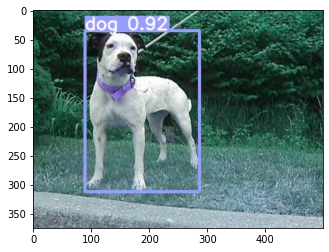

In [111]:
i = 72
plt.imshow(cv2.imread(paths[i]))